In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd gdrive/My Drive/TFM/

/content/gdrive/My Drive/TFM


In [ ]:
pip install dask[dataframe] --upgrade

     |████████████████████████████████| 132 kB 5.3 MB/s 


In [ ]:

import sys
import time
import datetime as dt
import multiprocessing as mp
from datetime import datetime
import pandas as pd

import re
import os

import pandas as pd
import pandas_datareader.data as web
from pandas import Timestamp

import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
#from numba import jit
import math


from itertools import cycle
from scipy import interp

# import visual tools
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from google.colab import drive





import glob

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Loading the data in this case with all symbols for a thoroughly study of the characteristics of different sampling pricedures

In [ ]:
# raw trade data from https://public.bitmex.com/?prefix=data/trade/ 
data = pd.DataFrame()
for i,file in enumerate(glob.glob("data/test/Data_0/*.csv")):
  if i == 0:
    data = data.append(pd.read_csv(file))
    print('Percentge of files already Loaded:',round((i/len(glob.glob("data/test/Data_0/*.csv")))*100,1), '%. There are', len(glob.glob("data/test/Data_0/*.csv"))-i, "files left", end='')
  else:
    data = data.append(pd.read_csv(file))
    print('\r Percentge of files already Loaded:',round((i/len(glob.glob("data/test/Data_0/*.csv")))*100,1), '%. There are', len(glob.glob("data/test/Data_0/*.csv"))-i, "files left",end='', flush=True)

 Percentge of files already Loaded: 96.3 %. There are 1 files left

In [ ]:
# raw trade data from https://public.bitmex.com/?prefix=data/trade/ 
data = pd.DataFrame()
for i,file in enumerate(glob.glob("data/test/Data_1/*.csv")):
  if i == 0:
    data = data.append(pd.read_csv(file))
    print('Percentge of files already Loaded:',round((i/len(glob.glob("data/test/Data_1/*.csv")))*100,1), '%. There are', len(glob.glob("data/test/Data_1/*.csv"))-i, "files left", end='')
  else:
    data = data.append(pd.read_csv(file))
    print('\r Percentge of files already Loaded:',round((i/len(glob.glob("data/test/Data_1/*.csv")))*100,1), '%. There are', len(glob.glob("data/test/Data_1/*.csv"))-i, "files left",end='', flush=True)

In [ ]:
# raw trade data from https://public.bitmex.com/?prefix=data/trade/ 
data = pd.DataFrame()
for i,file in enumerate(glob.glob("data/test/Data_2/*.csv")):
  if i == 0:
    data = data.append(pd.read_csv(file))
    print('Percentge of files already Loaded:',round((i/len(glob.glob("data/test/Data_2/*.csv")))*100,1), '%. There are', len(glob.glob("data/test/Data_2/*.csv"))-i, "files left", end='')
  else:
    data = data.append(pd.read_csv(file))
    print('\r Percentge of files already Loaded:',round((i/len(glob.glob("data/test/Data_2/*.csv")))*100,1), '%. There are', len(glob.glob("data/test/Data_2/*.csv"))-i, "files left",end='', flush=True)

In [ ]:
# raw trade data from https://public.bitmex.com/?prefix=data/trade/ 
data = pd.DataFrame()
for i,file in enumerate(glob.glob("data/test/Data_3/*.csv")):
  if i == 0:
    data = data.append(pd.read_csv(file))
    print('Percentge of files already Loaded:',round((i/len(glob.glob("data/test/Data_3/*.csv")))*100,1), '%. There are', len(glob.glob("data/test/Data_3/*.csv"))-i, "files left", end='')
  else:
    data = data.append(pd.read_csv(file))
    print('\r Percentge of files already Loaded:',round((i/len(glob.glob("data/test/Data_3/*.csv")))*100,1), '%. There are', len(glob.glob("data/test/Data_3/*.csv"))-i, "files left",end='', flush=True)

In [ ]:
set(data.symbol)

In [ ]:
data1 = data[data.symbol == 'ADAUSDT']
# timestamp parsing
data1['timestamp'] = data1.timestamp.map(lambda t: datetime.strptime(t[:-3], "%Y-%m-%dD%H:%M:%S.%f"))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#Experiment with Time and Tick bars for different time frames

In [ ]:
#SNIPPET 3.1 DAILY VOLATILITY ESTIMATES

def get_daily_vol(close, lookback=100):
    """
    :param close: (data frame) Closing prices
    :param lookback: (int) lookback period to compute volatility
    :return: (series) of daily volatility value
    """
    print('Calculating daily volatility for dynamic thresholds')
    
    df0 = close.index.searchsorted(close.index - pd.Timedelta(days=1))
    df0 = df0[df0 > 0]
    df0 = (pd.Series(close.index[df0 - 1], index=close.index[close.shape[0] - df0.shape[0]:]))
        
    df0 = close.loc[df0.index] / close.loc[df0.values].values - 1  # daily returns
    df0 = df0.ewm(span=lookback).std()
    return df0

In [ ]:
Time_bars_30m = data1.groupby(pd.Grouper(key="timestamp", freq="30min")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_30m.columns = ['open','high','low','close','size','timestamp']

In [ ]:
#Serial correlation aka auto correlation

def returns(candles_close_prices):
    return pd.Series(np.diff(np.log(candles_close_prices)))

In [ ]:
time_frames = ['5min','15m','30m','1h','4h','12h']
tick_frames = ['50', '100', '200', '500', '1000']
volume_frames = []
column_names = ['Time-5m','Time-15m','Time-30m','Time-1h','Time-4h','Time-12h','Tick-50', 'Tick-100', 'Tick-200', 'Tick-500', 'Tick-1000' ]
row_names = ['ADAUSDT','BNBUSDT','EOSUSDTH','DOTUSDT','ETHUSD','LINKUSDT','LTCUSD','XTZUSDT','XBTUSD','XRPUSD']

def bar(xs, y): return np.int64(xs / y) * y

correlations = pd.DataFrame(columns = column_names,index = row_names )

In [ ]:
Time_bars_5m = data1.groupby(pd.Grouper(key="timestamp", freq="5min")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_5m.columns = ['open','high','low','close','size','timestamp']
correlations.at['ADAUSDT','Time-5m'] = returns(Time_bars_5m['close']).autocorr(lag=1)


Time_bars_15m = data1.groupby(pd.Grouper(key="timestamp", freq="15min")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_15m.columns = ['open','high','low','close','size','timestamp']
correlations.at['ADAUSDT','Time-15m'] = returns(Time_bars_15m['close']).autocorr(lag=1)


Time_bars_30m = data1.groupby(pd.Grouper(key="timestamp", freq="30min")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_30m.columns = ['open','high','low','close','size','timestamp']
correlations.at['ADAUSDT','Time-30m'] = returns(Time_bars_30m['close']).autocorr(lag=1)


Time_bars_1h = data1.groupby(pd.Grouper(key="timestamp", freq="1h")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_1h.columns = ['open','high','low','close','size','timestamp']
correlations.at['ADAUSDT','Time-1h'] = returns(Time_bars_1h['close']).autocorr(lag=1)


Time_bars_4h = data1.groupby(pd.Grouper(key="timestamp", freq="4h")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_4h.columns = ['open','high','low','close','size','timestamp']
correlations.at['ADAUSDT','Time-4h'] = returns(Time_bars_4h['close']).autocorr(lag=1)


Time_bars_12h = data1.groupby(pd.Grouper(key="timestamp", freq="12h")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_12h.columns = ['open','high','low','close','size','timestamp']
correlations.at['ADAUSDT','Time-12h'] = returns(Time_bars_12h['close']).autocorr(lag=1)
correlations


Tick_50 = data1.groupby(bar(np.arange(len(data1)), 50 )).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first'})
Tick_50.columns = ['open','high','low','close','size','timestamp']
correlations.at['ADAUSDT','Tick-50'] = returns(Tick_50['close']).autocorr(lag=1)


Tick_100 = data1.groupby(bar(np.arange(len(data1)), 100 )).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first'})
Tick_100.columns = ['open','high','low','close','size','timestamp']
correlations.at['ADAUSDT','Tick-100'] = returns(Tick_100['close']).autocorr(lag=1)


Tick_200 = data1.groupby(bar(np.arange(len(data1)), 200 )).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first'})
Tick_200.columns = ['open','high','low','close','size','timestamp']
correlations.at['ADAUSDT','Tick-200'] = returns(Tick_200['close']).autocorr(lag=1)


Tick_500 = data1.groupby(bar(np.arange(len(data1)), 500 )).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first'})
Tick_500.columns = ['open','high','low','close','size','timestamp']
correlations.at['ADAUSDT','Tick-500'] = returns(Tick_500['close']).autocorr(lag=1)

Tick_1000 = data1.groupby(bar(np.arange(len(data1)), 1000 )).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first'})
Tick_1000.columns = ['open','high','low','close','size','timestamp']
correlations.at['ADAUSDT','Tick-1000'] = returns(Tick_1000['close']).autocorr(lag=1)


correlations


,Time-5m,Time-15m,Time-30m,Time-1h,Time-4h,Time-12h,Tick-50,Tick-100,Tick-200,Tick-500,Tick-1000
ADAUSDT,-0.201891,-0.147728,-0.0917009,-0.0780031,-0.0579267,0.138806,-0.0370446,-0.0809481,0.0394953,-0.00264455,-0.100816
BNBUSDT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EOSUSDTH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DOTUSDT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ETHUSD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LINKUSDT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LTCUSD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
XTZUSDTH21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TRXUSDT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UNIUSDT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data1 = data[data.symbol == 'BNBUSDTH21']

# timestamp parsing
data1['timestamp'] = data1.timestamp.map(lambda t: datetime.strptime(t[:-3], "%Y-%m-%dD%H:%M:%S.%f"))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
Time_bars_5m = data1.groupby(pd.Grouper(key="timestamp", freq="5min")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_5m.columns = ['open','high','low','close','size','timestamp']
correlations.at['BNBUSDT','Time-5m'] = returns(Time_bars_5m['close']).autocorr(lag=1)


Time_bars_15m = data1.groupby(pd.Grouper(key="timestamp", freq="15min")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_15m.columns = ['open','high','low','close','size','timestamp']
correlations.at['BNBUSDT','Time-15m'] = returns(Time_bars_15m['close']).autocorr(lag=1)


Time_bars_30m = data1.groupby(pd.Grouper(key="timestamp", freq="30min")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_30m.columns = ['open','high','low','close','size','timestamp']
correlations.at['BNBUSDT','Time-30m'] = returns(Time_bars_30m['close']).autocorr(lag=1)


Time_bars_1h = data1.groupby(pd.Grouper(key="timestamp", freq="1h")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_1h.columns = ['open','high','low','close','size','timestamp']
correlations.at['BNBUSDT','Time-1h'] = returns(Time_bars_1h['close']).autocorr(lag=1)


Time_bars_4h = data1.groupby(pd.Grouper(key="timestamp", freq="4h")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_4h.columns = ['open','high','low','close','size','timestamp']
correlations.at['BNBUSDT','Time-4h'] = returns(Time_bars_4h['close']).autocorr(lag=1)


Time_bars_12h = data1.groupby(pd.Grouper(key="timestamp", freq="12h")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_12h.columns = ['open','high','low','close','size','timestamp']
correlations.at['BNBUSDT','Time-12h'] = returns(Time_bars_12h['close']).autocorr(lag=1)
correlations



Tick_50 = data1.groupby(bar(np.arange(len(data1)), 50 )).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first'})
Tick_50.columns = ['open','high','low','close','size','timestamp']
correlations.at['BNBUSDT','Tick-50'] = returns(Tick_50['close']).autocorr(lag=1)


Tick_100 = data1.groupby(bar(np.arange(len(data1)), 100 )).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first'})
Tick_100.columns = ['open','high','low','close','size','timestamp']
correlations.at['BNBUSDT','Tick-100'] = returns(Tick_100['close']).autocorr(lag=1)


Tick_200 = data1.groupby(bar(np.arange(len(data1)), 200 )).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first'})
Tick_200.columns = ['open','high','low','close','size','timestamp']
correlations.at['BNBUSDT','Tick-200'] = returns(Tick_200['close']).autocorr(lag=1)


Tick_500 = data1.groupby(bar(np.arange(len(data1)), 500 )).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first'})
Tick_500.columns = ['open','high','low','close','size','timestamp']
correlations.at['BNBUSDT','Tick-500'] = returns(Tick_500['close']).autocorr(lag=1)

Tick_1000 = data1.groupby(bar(np.arange(len(data1)), 1000 )).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first'})
Tick_1000.columns = ['open','high','low','close','size','timestamp']
correlations.at['BNBUSDT','Tick-1000'] = returns(Tick_1000['close']).autocorr(lag=1)


correlations

,Time-5m,Time-15m,Time-30m,Time-1h,Time-4h,Time-12h,Tick-50,Tick-100,Tick-200,Tick-500,Tick-1000
ADAUSDT,-0.201891,-0.147728,-0.0917009,-0.0780031,-0.0579267,0.138806,-0.0370446,-0.0809481,0.0394953,-0.00264455,-0.100816
BNBUSDT,-0.201891,-0.147728,-0.0917009,-0.0780031,-0.0579267,0.138806,-0.0370446,-0.0809481,0.0394953,-0.00264455,-0.100816
EOSUSDTH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DOTUSDT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ETHUSD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LINKUSDT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LTCUSD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
XTZUSDTH21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TRXUSDT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UNIUSDT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data1 = data[data.symbol == 'EOSUSDTH21']
#del(data)
# timestamp parsing
data1['timestamp'] = data1.timestamp.map(lambda t: datetime.strptime(t[:-3], "%Y-%m-%dD%H:%M:%S.%f"))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
correlations.append(pd.Series(name='EOSUSDT'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



,Time-5m,Time-15m,Time-30m,Time-1h,Time-4h,Time-12h,Tick-50,Tick-100,Tick-200,Tick-500,Tick-1000
ADAUSDT,-0.201891,-0.147728,-0.0917009,-0.0780031,-0.0579267,0.138806,-0.0370446,-0.0809481,0.0394953,-0.00264455,-0.100816
BNBUSDT,-0.201891,-0.147728,-0.0917009,-0.0780031,-0.0579267,0.138806,-0.0370446,-0.0809481,0.0394953,-0.00264455,-0.100816
EOSUSDTH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DOTUSDT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ETHUSD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LINKUSDT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LTCUSD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
XTZUSDTH21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TRXUSDT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UNIUSDT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
Time_bars_5m = data1.groupby(pd.Grouper(key="timestamp", freq="5min")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_5m.columns = ['open','high','low','close','size','timestamp']
correlations.at['EOSUSDT','Time-5m'] = returns(Time_bars_5m['close']).autocorr(lag=1)


Time_bars_15m = data1.groupby(pd.Grouper(key="timestamp", freq="15min")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_15m.columns = ['open','high','low','close','size','timestamp']
correlations.at['EOSUSDT','Time-15m'] = returns(Time_bars_15m['close']).autocorr(lag=1)


Time_bars_30m = data1.groupby(pd.Grouper(key="timestamp", freq="30min")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_30m.columns = ['open','high','low','close','size','timestamp']
correlations.at['EOSUSDT','Time-30m'] = returns(Time_bars_30m['close']).autocorr(lag=1)


Time_bars_1h = data1.groupby(pd.Grouper(key="timestamp", freq="1h")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_1h.columns = ['open','high','low','close','size','timestamp']
correlations.at['EOSUSDT','Time-1h'] = returns(Time_bars_1h['close']).autocorr(lag=1)


Time_bars_4h = data1.groupby(pd.Grouper(key="timestamp", freq="4h")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_4h.columns = ['open','high','low','close','size','timestamp']
correlations.at['EOSUSDT','Time-4h'] = returns(Time_bars_4h['close']).autocorr(lag=1)


Time_bars_12h = data1.groupby(pd.Grouper(key="timestamp", freq="12h")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_12h.columns = ['open','high','low','close','size','timestamp']
correlations.at['EOSUSDT','Time-12h'] = returns(Time_bars_12h['close']).autocorr(lag=1)
correlations



Tick_50 = data1.groupby(bar(np.arange(len(data1)), 50 )).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first'})
Tick_50.columns = ['open','high','low','close','size','timestamp']
correlations.at['EOSUSDT','Tick-50'] = returns(Tick_50['close']).autocorr(lag=1)


Tick_100 = data1.groupby(bar(np.arange(len(data1)), 100 )).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first'})
Tick_100.columns = ['open','high','low','close','size','timestamp']
correlations.at['EOSUSDT','Tick-100'] = returns(Tick_100['close']).autocorr(lag=1)


Tick_200 = data1.groupby(bar(np.arange(len(data1)), 200 )).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first'})
Tick_200.columns = ['open','high','low','close','size','timestamp']
correlations.at['EOSUSDT','Tick-200'] = returns(Tick_200['close']).autocorr(lag=1)


Tick_500 = data1.groupby(bar(np.arange(len(data1)), 500 )).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first'})
Tick_500.columns = ['open','high','low','close','size','timestamp']
correlations.at['EOSUSDT','Tick-500'] = returns(Tick_500['close']).autocorr(lag=1)

Tick_1000 = data1.groupby(bar(np.arange(len(data1)), 1000 )).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first'})
Tick_1000.columns = ['open','high','low','close','size','timestamp']
correlations.at['EOSUSDT','Tick-1000'] = returns(Tick_1000['close']).autocorr(lag=1)


correlations

,Time-5m,Time-15m,Time-30m,Time-1h,Time-4h,Time-12h,Tick-50,Tick-100,Tick-200,Tick-500,Tick-1000
ADAUSDT,-0.201891,-0.147728,-0.0917009,-0.0780031,-0.0579267,0.138806,-0.0370446,-0.0809481,0.0394953,-0.00264455,-0.100816
BNBUSDT,-0.201891,-0.147728,-0.0917009,-0.0780031,-0.0579267,0.138806,-0.0370446,-0.0809481,0.0394953,-0.00264455,-0.100816
EOSUSDTH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DOTUSDT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ETHUSD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LINKUSDT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LTCUSD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
XTZUSDTH21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TRXUSDT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UNIUSDT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data1 = data[data.symbol == 'DOTUSDTH21']

# timestamp parsing
data1['timestamp'] = data1.timestamp.map(lambda t: datetime.strptime(t[:-3], "%Y-%m-%dD%H:%M:%S.%f"))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
Time_bars_5m = data1.groupby(pd.Grouper(key="timestamp", freq="5min")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_5m.columns = ['open','high','low','close','size','timestamp']
correlations.at['DOTUSDT','Time-5m'] = returns(Time_bars_5m['close']).autocorr(lag=1)


Time_bars_15m = data1.groupby(pd.Grouper(key="timestamp", freq="15min")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_15m.columns = ['open','high','low','close','size','timestamp']
correlations.at['DOTUSDT','Time-15m'] = returns(Time_bars_15m['close']).autocorr(lag=1)


Time_bars_30m = data1.groupby(pd.Grouper(key="timestamp", freq="30min")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_30m.columns = ['open','high','low','close','size','timestamp']
correlations.at['DOTUSDT','Time-30m'] = returns(Time_bars_30m['close']).autocorr(lag=1)


Time_bars_1h = data1.groupby(pd.Grouper(key="timestamp", freq="1h")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_1h.columns = ['open','high','low','close','size','timestamp']
correlations.at['DOTUSDT','Time-1h'] = returns(Time_bars_1h['close']).autocorr(lag=1)


Time_bars_4h = data1.groupby(pd.Grouper(key="timestamp", freq="4h")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_4h.columns = ['open','high','low','close','size','timestamp']
correlations.at['DOTUSDT','Time-4h'] = returns(Time_bars_4h['close']).autocorr(lag=1)


Time_bars_12h = data1.groupby(pd.Grouper(key="timestamp", freq="12h")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_12h.columns = ['open','high','low','close','size','timestamp']
correlations.at['DOTUSDT','Time-12h'] = returns(Time_bars_12h['close']).autocorr(lag=1)
correlations



Tick_50 = data1.groupby(bar(np.arange(len(data1)), 50 )).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first'})
Tick_50.columns = ['open','high','low','close','size','timestamp']
correlations.at['DOTUSDT','Tick-50'] = returns(Tick_50['close']).autocorr(lag=1)


Tick_100 = data1.groupby(bar(np.arange(len(data1)), 100 )).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first'})
Tick_100.columns = ['open','high','low','close','size','timestamp']
correlations.at['DOTUSDT','Tick-100'] = returns(Tick_100['close']).autocorr(lag=1)


Tick_200 = data1.groupby(bar(np.arange(len(data1)), 200 )).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first'})
Tick_200.columns = ['open','high','low','close','size','timestamp']
correlations.at['DOTUSDT','Tick-200'] = returns(Tick_200['close']).autocorr(lag=1)


Tick_500 = data1.groupby(bar(np.arange(len(data1)), 500 )).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first'})
Tick_500.columns = ['open','high','low','close','size','timestamp']
correlations.at['DOTUSDT','Tick-500'] = returns(Tick_500['close']).autocorr(lag=1)

Tick_1000 = data1.groupby(bar(np.arange(len(data1)), 1000 )).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first'})
Tick_1000.columns = ['open','high','low','close','size','timestamp']
correlations.at['DOTUSDT','Tick-1000'] = returns(Tick_1000['close']).autocorr(lag=1)


correlations

,Time-5m,Time-15m,Time-30m,Time-1h,Time-4h,Time-12h,Tick-50,Tick-100,Tick-200,Tick-500,Tick-1000
ADAUSDT,-0.201891,-0.147728,-0.0917009,-0.0780031,-0.0579267,0.138806,-0.0370446,-0.0809481,0.0394953,-0.00264455,-0.100816
BNBUSDT,-0.201891,-0.147728,-0.0917009,-0.0780031,-0.0579267,0.138806,-0.0370446,-0.0809481,0.0394953,-0.00264455,-0.100816
EOSUSDTH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DOTUSDT,-0.142672,-0.16993,-0.191981,-0.123661,-0.118537,-0.105342,0.00639274,-0.0347454,0.0268247,-0.105154,-0.466868
ETHUSD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LINKUSDT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LTCUSD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
XTZUSDTH21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TRXUSDT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UNIUSDT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data1 = data[data.symbol == 'ETHUSD']
#del(data)
# timestamp parsing
data1['timestamp'] = data1.timestamp.map(lambda t: datetime.strptime(t[:-3], "%Y-%m-%dD%H:%M:%S.%f"))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
Time_bars_5m = data1.groupby(pd.Grouper(key="timestamp", freq="5min")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_5m.columns = ['open','high','low','close','size','timestamp']
correlations.at['ETHUSD','Time-5m'] = returns(Time_bars_5m['close']).autocorr(lag=1)


Time_bars_15m = data1.groupby(pd.Grouper(key="timestamp", freq="15min")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_15m.columns = ['open','high','low','close','size','timestamp']
correlations.at['ETHUSD','Time-15m'] = returns(Time_bars_15m['close']).autocorr(lag=1)


Time_bars_30m = data1.groupby(pd.Grouper(key="timestamp", freq="30min")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_30m.columns = ['open','high','low','close','size','timestamp']
correlations.at['ETHUSD','Time-30m'] = returns(Time_bars_30m['close']).autocorr(lag=1)


Time_bars_1h = data1.groupby(pd.Grouper(key="timestamp", freq="1h")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_1h.columns = ['open','high','low','close','size','timestamp']
correlations.at['ETHUSD','Time-1h'] = returns(Time_bars_1h['close']).autocorr(lag=1)


Time_bars_4h = data1.groupby(pd.Grouper(key="timestamp", freq="4h")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_4h.columns = ['open','high','low','close','size','timestamp']
correlations.at['ETHUSD','Time-4h'] = returns(Time_bars_4h['close']).autocorr(lag=1)


Time_bars_12h = data1.groupby(pd.Grouper(key="timestamp", freq="12h")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_12h.columns = ['open','high','low','close','size','timestamp']
correlations.at['ETHUSD','Time-12h'] = returns(Time_bars_12h['close']).autocorr(lag=1)
correlations



Tick_50 = data1.groupby(bar(np.arange(len(data1)), 50 )).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first'})
Tick_50.columns = ['open','high','low','close','size','timestamp']
correlations.at['ETHUSD','Tick-50'] = returns(Tick_50['close']).autocorr(lag=1)


Tick_100 = data1.groupby(bar(np.arange(len(data1)), 100 )).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first'})
Tick_100.columns = ['open','high','low','close','size','timestamp']
correlations.at['ETHUSD','Tick-100'] = returns(Tick_100['close']).autocorr(lag=1)


Tick_200 = data1.groupby(bar(np.arange(len(data1)), 200 )).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first'})
Tick_200.columns = ['open','high','low','close','size','timestamp']
correlations.at['ETHUSD','Tick-200'] = returns(Tick_200['close']).autocorr(lag=1)


Tick_500 = data1.groupby(bar(np.arange(len(data1)), 500 )).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first'})
Tick_500.columns = ['open','high','low','close','size','timestamp']
correlations.at['ETHUSD','Tick-500'] = returns(Tick_500['close']).autocorr(lag=1)

Tick_1000 = data1.groupby(bar(np.arange(len(data1)), 1000 )).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first'})
Tick_1000.columns = ['open','high','low','close','size','timestamp']
correlations.at['ETHUSD','Tick-1000'] = returns(Tick_1000['close']).autocorr(lag=1)


correlations

,Time-5m,Time-15m,Time-30m,Time-1h,Time-4h,Time-12h,Tick-50,Tick-100,Tick-200,Tick-500,Tick-1000
ADAUSDT,-0.201891,-0.147728,-0.0917009,-0.0780031,-0.0579267,0.138806,-0.0370446,-0.0809481,0.0394953,-0.00264455,-0.100816
BNBUSDT,-0.201891,-0.147728,-0.0917009,-0.0780031,-0.0579267,0.138806,-0.0370446,-0.0809481,0.0394953,-0.00264455,-0.100816
EOSUSDTH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DOTUSDT,-0.142672,-0.16993,-0.191981,-0.123661,-0.118537,-0.105342,0.00639274,-0.0347454,0.0268247,-0.105154,-0.466868
ETHUSD,-0.0600111,0.0237141,-0.0207546,0.0305456,-0.0704298,-0.0377073,-0.0300683,0.0143217,0.0114848,0.0262042,0.035846
LINKUSDT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LTCUSD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
XTZUSDTH21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TRXUSDT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UNIUSDT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data1 = data[data.symbol == 'LINKUSDT'] 
#del(data)
# timestamp parsing
data1['timestamp'] = data1.timestamp.map(lambda t: datetime.strptime(t[:-3], "%Y-%m-%dD%H:%M:%S.%f"))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
Time_bars_5m = data1.groupby(pd.Grouper(key="timestamp", freq="5min")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_5m.columns = ['open','high','low','close','size','timestamp']
correlations.at['LINKUSDT','Time-5m'] = returns(Time_bars_5m['close']).autocorr(lag=1)


Time_bars_15m = data1.groupby(pd.Grouper(key="timestamp", freq="15min")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_15m.columns = ['open','high','low','close','size','timestamp']
correlations.at['LINKUSDT','Time-15m'] = returns(Time_bars_15m['close']).autocorr(lag=1)


Time_bars_30m = data1.groupby(pd.Grouper(key="timestamp", freq="30min")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_30m.columns = ['open','high','low','close','size','timestamp']
correlations.at['LINKUSDT','Time-30m'] = returns(Time_bars_30m['close']).autocorr(lag=1)


Time_bars_1h = data1.groupby(pd.Grouper(key="timestamp", freq="1h")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_1h.columns = ['open','high','low','close','size','timestamp']
correlations.at['LINKUSDT','Time-1h'] = returns(Time_bars_1h['close']).autocorr(lag=1)


Time_bars_4h = data1.groupby(pd.Grouper(key="timestamp", freq="4h")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_4h.columns = ['open','high','low','close','size','timestamp']
correlations.at['LINKUSDT','Time-4h'] = returns(Time_bars_4h['close']).autocorr(lag=1)


Time_bars_12h = data1.groupby(pd.Grouper(key="timestamp", freq="12h")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_12h.columns = ['open','high','low','close','size','timestamp']
correlations.at['LINKUSDT','Time-12h'] = returns(Time_bars_12h['close']).autocorr(lag=1)
correlations


Tick_50 = data1.groupby(bar(np.arange(len(data1)), 50 )).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first'})
Tick_50.columns = ['open','high','low','close','size','timestamp']
correlations.at['LINKUSDT','Tick-50'] = returns(Tick_50['close']).autocorr(lag=1)


Tick_100 = data1.groupby(bar(np.arange(len(data1)), 100 )).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first'})
Tick_100.columns = ['open','high','low','close','size','timestamp']
correlations.at['LINKUSDT','Tick-100'] = returns(Tick_100['close']).autocorr(lag=1)


Tick_200 = data1.groupby(bar(np.arange(len(data1)), 200 )).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first'})
Tick_200.columns = ['open','high','low','close','size','timestamp']
correlations.at['LINKUSDT','Tick-200'] = returns(Tick_200['close']).autocorr(lag=1)


Tick_500 = data1.groupby(bar(np.arange(len(data1)), 500 )).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first'})
Tick_500.columns = ['open','high','low','close','size','timestamp']
correlations.at['LINKUSDT','Tick-500'] = returns(Tick_500['close']).autocorr(lag=1)

Tick_1000 = data1.groupby(bar(np.arange(len(data1)), 1000 )).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first'})
Tick_1000.columns = ['open','high','low','close','size','timestamp']
correlations.at['LINKUSDT','Tick-1000'] = returns(Tick_1000['close']).autocorr(lag=1)


correlations

,Time-5m,Time-15m,Time-30m,Time-1h,Time-4h,Time-12h,Tick-50,Tick-100,Tick-200,Tick-500,Tick-1000
ADAUSDT,-0.201891,-0.147728,-0.0917009,-0.0780031,-0.0579267,0.138806,-0.0370446,-0.0809481,0.0394953,-0.00264455,-0.100816
BNBUSDT,-0.201891,-0.147728,-0.0917009,-0.0780031,-0.0579267,0.138806,-0.0370446,-0.0809481,0.0394953,-0.00264455,-0.100816
EOSUSDTH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DOTUSDT,-0.142672,-0.16993,-0.191981,-0.123661,-0.118537,-0.105342,0.00639274,-0.0347454,0.0268247,-0.105154,-0.466868
ETHUSD,-0.0600111,0.0237141,-0.0207546,0.0305456,-0.0704298,-0.0377073,-0.0300683,0.0143217,0.0114848,0.0262042,0.035846
LINKUSDT,-0.055438,0.0124228,-0.0250836,0.00693413,-0.0454013,-0.0588843,0.0192547,0.0490144,0.0446241,0.038406,0.0115062
LTCUSD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
XTZUSDTH21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TRXUSDT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UNIUSDT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data1 = data[data.symbol == 'LTCUSD']
# timestamp parsing 
data1['timestamp'] = data1.timestamp.map(lambda t: datetime.strptime(t[:-3], "%Y-%m-%dD%H:%M:%S.%f"))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
Time_bars_5m = data1.groupby(pd.Grouper(key="timestamp", freq="5min")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_5m.columns = ['open','high','low','close','size','timestamp']
correlations.at['LTCUSD','Time-5m'] = returns(Time_bars_5m['close']).autocorr(lag=1)


Time_bars_15m = data1.groupby(pd.Grouper(key="timestamp", freq="15min")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_15m.columns = ['open','high','low','close','size','timestamp']
correlations.at['LTCUSD','Time-15m'] = returns(Time_bars_15m['close']).autocorr(lag=1)


Time_bars_30m = data1.groupby(pd.Grouper(key="timestamp", freq="30min")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_30m.columns = ['open','high','low','close','size','timestamp']
correlations.at['LTCUSD','Time-30m'] = returns(Time_bars_30m['close']).autocorr(lag=1)


Time_bars_1h = data1.groupby(pd.Grouper(key="timestamp", freq="1h")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_1h.columns = ['open','high','low','close','size','timestamp']
correlations.at['LTCUSD','Time-1h'] = returns(Time_bars_1h['close']).autocorr(lag=1)


Time_bars_4h = data1.groupby(pd.Grouper(key="timestamp", freq="4h")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_4h.columns = ['open','high','low','close','size','timestamp']
correlations.at['LTCUSD','Time-4h'] = returns(Time_bars_4h['close']).autocorr(lag=1)


Time_bars_12h = data1.groupby(pd.Grouper(key="timestamp", freq="12h")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_12h.columns = ['open','high','low','close','size','timestamp']
correlations.at['LTCUSD','Time-12h'] = returns(Time_bars_12h['close']).autocorr(lag=1)



Tick_50 = data1.groupby(bar(np.arange(len(data1)), 50 )).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first'})
Tick_50.columns = ['open','high','low','close','size','timestamp']
correlations.at['LTCUSD','Tick-50'] = returns(Tick_50['close']).autocorr(lag=1)


Tick_100 = data1.groupby(bar(np.arange(len(data1)), 100 )).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first'})
Tick_100.columns = ['open','high','low','close','size','timestamp']
correlations.at['LTCUSD','Tick-100'] = returns(Tick_100['close']).autocorr(lag=1)


Tick_200 = data1.groupby(bar(np.arange(len(data1)), 200 )).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first'})
Tick_200.columns = ['open','high','low','close','size','timestamp']
correlations.at['LTCUSD','Tick-200'] = returns(Tick_200['close']).autocorr(lag=1)


Tick_500 = data1.groupby(bar(np.arange(len(data1)), 500 )).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first'})
Tick_500.columns = ['open','high','low','close','size','timestamp']
correlations.at['LTCUSD','Tick-500'] = returns(Tick_500['close']).autocorr(lag=1)

Tick_1000 = data1.groupby(bar(np.arange(len(data1)), 1000 )).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first'})
Tick_1000.columns = ['open','high','low','close','size','timestamp']
correlations.at['LTCUSD','Tick-1000'] = returns(Tick_1000['close']).autocorr(lag=1)


correlations

,Time-5m,Time-15m,Time-30m,Time-1h,Time-4h,Time-12h,Tick-50,Tick-100,Tick-200,Tick-500,Tick-1000
ADAUSDT,-0.201891,-0.147728,-0.0917009,-0.0780031,-0.0579267,0.138806,-0.0370446,-0.0809481,0.0394953,-0.00264455,-0.100816
BNBUSDT,-0.201891,-0.147728,-0.0917009,-0.0780031,-0.0579267,0.138806,-0.0370446,-0.0809481,0.0394953,-0.00264455,-0.100816
EOSUSDTH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DOTUSDT,-0.142672,-0.16993,-0.191981,-0.123661,-0.118537,-0.105342,0.00639274,-0.0347454,0.0268247,-0.105154,-0.466868
ETHUSD,-0.0600111,0.0237141,-0.0207546,0.0305456,-0.0704298,-0.0377073,-0.0300683,0.0143217,0.0114848,0.0262042,0.035846
LINKUSDT,-0.055438,0.0124228,-0.0250836,0.00693413,-0.0454013,-0.0588843,0.0192547,0.0490144,0.0446241,0.038406,0.0115062
LTCUSD,-0.0163598,0.0355802,-0.0838899,-0.06293,-0.020697,-0.0339745,0.00526709,0.00160454,-0.00565787,0.0264317,-0.000908898
XTZUSDTH21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TRXUSDT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UNIUSDT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
correlations = correlations.rename(index={'SOLUSDT': 'LTCUSD'})

In [ ]:
data1 = data[data.symbol == 'XTZUSDTH21']
# timestamp parsing 
data1['timestamp'] = data1.timestamp.map(lambda t: datetime.strptime(t[:-3], "%Y-%m-%dD%H:%M:%S.%f"))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
Time_bars_5m = data1.groupby(pd.Grouper(key="timestamp", freq="5min")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_5m.columns = ['open','high','low','close','size','timestamp']
correlations.at['XTZUSDT','Time-5m'] = returns(Time_bars_5m['close']).autocorr(lag=1)


Time_bars_15m = data1.groupby(pd.Grouper(key="timestamp", freq="15min")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_15m.columns = ['open','high','low','close','size','timestamp']
correlations.at['XTZUSDT','Time-15m'] = returns(Time_bars_15m['close']).autocorr(lag=1)


Time_bars_30m = data1.groupby(pd.Grouper(key="timestamp", freq="30min")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_30m.columns = ['open','high','low','close','size','timestamp']
correlations.at['XTZUSDT','Time-30m'] = returns(Time_bars_30m['close']).autocorr(lag=1)


Time_bars_1h = data1.groupby(pd.Grouper(key="timestamp", freq="1h")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_1h.columns = ['open','high','low','close','size','timestamp']
correlations.at['XTZUSDT','Time-1h'] = returns(Time_bars_1h['close']).autocorr(lag=1)


Time_bars_4h = data1.groupby(pd.Grouper(key="timestamp", freq="4h")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_4h.columns = ['open','high','low','close','size','timestamp']
correlations.at['XTZUSDT','Time-4h'] = returns(Time_bars_4h['close']).autocorr(lag=1)


Time_bars_12h = data1.groupby(pd.Grouper(key="timestamp", freq="12h")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_12h.columns = ['open','high','low','close','size','timestamp']
correlations.at['XTZUSDT','Time-12h'] = returns(Time_bars_12h['close']).autocorr(lag=1)
correlations


Tick_50 = data1.groupby(bar(np.arange(len(data1)), 50 )).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first'})
Tick_50.columns = ['open','high','low','close','size','timestamp']
correlations.at['XTZUSDT','Tick-50'] = returns(Tick_50['close']).autocorr(lag=1)


Tick_100 = data1.groupby(bar(np.arange(len(data1)), 100 )).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first'})
Tick_100.columns = ['open','high','low','close','size','timestamp']
correlations.at['XTZUSDT','Tick-100'] = returns(Tick_100['close']).autocorr(lag=1)


Tick_200 = data1.groupby(bar(np.arange(len(data1)), 200 )).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first'})
Tick_200.columns = ['open','high','low','close','size','timestamp']
correlations.at['XTZUSDT','Tick-200'] = returns(Tick_200['close']).autocorr(lag=1)


Tick_500 = data1.groupby(bar(np.arange(len(data1)), 500 )).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first'})
Tick_500.columns = ['open','high','low','close','size','timestamp']
correlations.at['XTZUSDT','Tick-500'] = returns(Tick_500['close']).autocorr(lag=1)

Tick_1000 = data1.groupby(bar(np.arange(len(data1)), 1000 )).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first'})
Tick_1000.columns = ['open','high','low','close','size','timestamp']
correlations.at['XTZUSDT','Tick-1000'] = returns(Tick_1000['close']).autocorr(lag=1)


correlations

,Time-5m,Time-15m,Time-30m,Time-1h,Time-4h,Time-12h,Tick-50,Tick-100,Tick-200,Tick-500,Tick-1000
ADAUSDT,-0.201891,-0.147728,-0.0917009,-0.0780031,-0.0579267,0.138806,-0.0370446,-0.0809481,0.0394953,-0.00264455,-0.100816
BNBUSDT,-0.201891,-0.147728,-0.0917009,-0.0780031,-0.0579267,0.138806,-0.0370446,-0.0809481,0.0394953,-0.00264455,-0.100816
EOSUSDTH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DOTUSDT,-0.142672,-0.16993,-0.191981,-0.123661,-0.118537,-0.105342,0.00639274,-0.0347454,0.0268247,-0.105154,-0.466868
ETHUSD,-0.0600111,0.0237141,-0.0207546,0.0305456,-0.0704298,-0.0377073,-0.0300683,0.0143217,0.0114848,0.0262042,0.035846
LINKUSDT,-0.055438,0.0124228,-0.0250836,0.00693413,-0.0454013,-0.0588843,0.0192547,0.0490144,0.0446241,0.038406,0.0115062
LTCUSD,-0.0163598,0.0355802,-0.0838899,-0.06293,-0.020697,-0.0339745,0.00526709,0.00160454,-0.00565787,0.0264317,-0.000908898
XTZUSDTH21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TRXUSDT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UNIUSDT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data1 = data[data.symbol == 'YFIUSDTH21']
# timestamp parsing 
data1['timestamp'] = data1.timestamp.map(lambda t: datetime.strptime(t[:-3], "%Y-%m-%dD%H:%M:%S.%f"))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
correlations = correlations.rename(index={'TRXUSD': 'YFIUSDT'})

Time_bars_5m = data1.groupby(pd.Grouper(key="timestamp", freq="5min")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_5m.columns = ['open','high','low','close','size','timestamp']
correlations.at['YFIUSDT','Time-5m'] = returns(Time_bars_5m['close']).autocorr(lag=1)


Time_bars_15m = data1.groupby(pd.Grouper(key="timestamp", freq="15min")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_15m.columns = ['open','high','low','close','size','timestamp']
correlations.at['YFIUSDT','Time-15m'] = returns(Time_bars_15m['close']).autocorr(lag=1)


Time_bars_30m = data1.groupby(pd.Grouper(key="timestamp", freq="30min")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_30m.columns = ['open','high','low','close','size','timestamp']
correlations.at['YFIUSDT','Time-30m'] = returns(Time_bars_30m['close']).autocorr(lag=1)


Time_bars_1h = data1.groupby(pd.Grouper(key="timestamp", freq="1h")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_1h.columns = ['open','high','low','close','size','timestamp']
correlations.at['YFIUSDT','Time-1h'] = returns(Time_bars_1h['close']).autocorr(lag=1)


Time_bars_4h = data1.groupby(pd.Grouper(key="timestamp", freq="4h")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_4h.columns = ['open','high','low','close','size','timestamp']
correlations.at['YFIUSDT','Time-4h'] = returns(Time_bars_4h['close']).autocorr(lag=1)


Time_bars_12h = data1.groupby(pd.Grouper(key="timestamp", freq="12h")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_12h.columns = ['open','high','low','close','size','timestamp']
correlations.at['YFIUSDT','Time-12h'] = returns(Time_bars_12h['close']).autocorr(lag=1)
correlations


Tick_50 = data1.groupby(bar(np.arange(len(data1)), 50 )).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first'})
Tick_50.columns = ['open','high','low','close','size','timestamp']
correlations.at['YFIUSDT','Tick-50'] = returns(Tick_50['close']).autocorr(lag=1)


Tick_100 = data1.groupby(bar(np.arange(len(data1)), 100 )).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first'})
Tick_100.columns = ['open','high','low','close','size','timestamp']
correlations.at['YFIUSDT','Tick-100'] = returns(Tick_100['close']).autocorr(lag=1)


Tick_200 = data1.groupby(bar(np.arange(len(data1)), 200 )).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first'})
Tick_200.columns = ['open','high','low','close','size','timestamp']
correlations.at['YFIUSDT','Tick-200'] = returns(Tick_200['close']).autocorr(lag=1)


Tick_500 = data1.groupby(bar(np.arange(len(data1)), 500 )).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first'})
Tick_500.columns = ['open','high','low','close','size','timestamp']
correlations.at['YFIUSDT','Tick-500'] = returns(Tick_500['close']).autocorr(lag=1)

Tick_1000 = data1.groupby(bar(np.arange(len(data1)), 1000 )).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first'})
Tick_1000.columns = ['open','high','low','close','size','timestamp']
correlations.at['YFIUSDT','Tick-1000'] = returns(Tick_1000['close']).autocorr(lag=1)

correlations

,Time-5m,Time-15m,Time-30m,Time-1h,Time-4h,Time-12h,Tick-50,Tick-100,Tick-200,Tick-500,Tick-1000
ADAUSDT,-0.201891,-0.147728,-0.0917009,-0.0780031,-0.0579267,0.138806,-0.0370446,-0.0809481,0.0394953,-0.00264455,-0.100816
BNBUSDT,-0.201891,-0.147728,-0.0917009,-0.0780031,-0.0579267,0.138806,-0.0370446,-0.0809481,0.0394953,-0.00264455,-0.100816
EOSUSDTH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DOTUSDT,-0.142672,-0.16993,-0.191981,-0.123661,-0.118537,-0.105342,0.00639274,-0.0347454,0.0268247,-0.105154,-0.466868
ETHUSD,-0.0600111,0.0237141,-0.0207546,0.0305456,-0.0704298,-0.0377073,-0.0300683,0.0143217,0.0114848,0.0262042,0.035846
LINKUSDT,-0.055438,0.0124228,-0.0250836,0.00693413,-0.0454013,-0.0588843,0.0192547,0.0490144,0.0446241,0.038406,0.0115062
LTCUSD,-0.0163598,0.0355802,-0.0838899,-0.06293,-0.020697,-0.0339745,0.00526709,0.00160454,-0.00565787,0.0264317,-0.000908898
XTZUSDTH21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TRXUSDT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UNIUSDT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data1 = data[data.symbol == 'XBTUSD']
# timestamp parsing 
data1['timestamp'] = data1.timestamp.map(lambda t: datetime.strptime(t[:-3], "%Y-%m-%dD%H:%M:%S.%f"))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
Time_bars_5m = data1.groupby(pd.Grouper(key="timestamp", freq="5min")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_5m.columns = ['open','high','low','close','size','timestamp']
correlations.at['XBTUSD','Time-5m'] = returns(Time_bars_5m['close']).autocorr(lag=1)


Time_bars_15m = data1.groupby(pd.Grouper(key="timestamp", freq="15min")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_15m.columns = ['open','high','low','close','size','timestamp']
correlations.at['XBTUSD','Time-15m'] = returns(Time_bars_15m['close']).autocorr(lag=1)


Time_bars_30m = data1.groupby(pd.Grouper(key="timestamp", freq="30min")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_30m.columns = ['open','high','low','close','size','timestamp']
correlations.at['XBTUSD','Time-30m'] = returns(Time_bars_30m['close']).autocorr(lag=1)


Time_bars_1h = data1.groupby(pd.Grouper(key="timestamp", freq="1h")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_1h.columns = ['open','high','low','close','size','timestamp']
correlations.at['XBTUSD','Time-1h'] = returns(Time_bars_1h['close']).autocorr(lag=1)


Time_bars_4h = data1.groupby(pd.Grouper(key="timestamp", freq="4h")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_4h.columns = ['open','high','low','close','size','timestamp']
correlations.at['XBTUSD','Time-4h'] = returns(Time_bars_4h['close']).autocorr(lag=1)


Time_bars_12h = data1.groupby(pd.Grouper(key="timestamp", freq="12h")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_12h.columns = ['open','high','low','close','size','timestamp']
correlations.at['XBTUSD','Time-12h'] = returns(Time_bars_12h['close']).autocorr(lag=1)
correlations


Tick_50 = data1.groupby(bar(np.arange(len(data1)), 50 )).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first'})
Tick_50.columns = ['open','high','low','close','size','timestamp']
correlations.at['XBTUSD','Tick-50'] = returns(Tick_50['close']).autocorr(lag=1)


Tick_100 = data1.groupby(bar(np.arange(len(data1)), 100 )).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first'})
Tick_100.columns = ['open','high','low','close','size','timestamp']
correlations.at['XBTUSD','Tick-100'] = returns(Tick_100['close']).autocorr(lag=1)


Tick_200 = data1.groupby(bar(np.arange(len(data1)), 200 )).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first'})
Tick_200.columns = ['open','high','low','close','size','timestamp']
correlations.at['XBTUSD','Tick-200'] = returns(Tick_200['close']).autocorr(lag=1)


Tick_500 = data1.groupby(bar(np.arange(len(data1)), 500 )).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first'})
Tick_500.columns = ['open','high','low','close','size','timestamp']
correlations.at['XBTUSD','Tick-500'] = returns(Tick_500['close']).autocorr(lag=1)

Tick_1000 = data1.groupby(bar(np.arange(len(data1)), 1000 )).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first'})
Tick_1000.columns = ['open','high','low','close','size','timestamp']
correlations.at['XBTUSD','Tick-1000'] = returns(Tick_1000['close']).autocorr(lag=1)


correlations

,Time-5m,Time-15m,Time-30m,Time-1h,Time-4h,Time-12h,Tick-50,Tick-100,Tick-200,Tick-500,Tick-1000
ADAUSDT,-0.201891,-0.147728,-0.0917009,-0.0780031,-0.0579267,0.138806,-0.0370446,-0.0809481,0.0394953,-0.00264455,-0.100816
BNBUSDT,-0.201891,-0.147728,-0.0917009,-0.0780031,-0.0579267,0.138806,-0.0370446,-0.0809481,0.0394953,-0.00264455,-0.100816
EOSUSDTH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DOTUSDT,-0.142672,-0.16993,-0.191981,-0.123661,-0.118537,-0.105342,0.00639274,-0.0347454,0.0268247,-0.105154,-0.466868
ETHUSD,-0.0600111,0.0237141,-0.0207546,0.0305456,-0.0704298,-0.0377073,-0.0300683,0.0143217,0.0114848,0.0262042,0.035846
LINKUSDT,-0.055438,0.0124228,-0.0250836,0.00693413,-0.0454013,-0.0588843,0.0192547,0.0490144,0.0446241,0.038406,0.0115062
LTCUSD,-0.0163598,0.0355802,-0.0838899,-0.06293,-0.020697,-0.0339745,0.00526709,0.00160454,-0.00565787,0.0264317,-0.000908898
XTZUSDTH21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TRXUSDT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UNIUSDT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data1 = data[data.symbol == 'XRPUSD']
# timestamp parsing 
data1['timestamp'] = data1.timestamp.map(lambda t: datetime.strptime(t[:-3], "%Y-%m-%dD%H:%M:%S.%f"))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
Time_bars_5m = data1.groupby(pd.Grouper(key="timestamp", freq="5min")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_5m.columns = ['open','high','low','close','size','timestamp']
correlations.at['XRPUSD','Time-5m'] = returns(Time_bars_5m['close']).autocorr(lag=1)


Time_bars_15m = data1.groupby(pd.Grouper(key="timestamp", freq="15min")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_15m.columns = ['open','high','low','close','size','timestamp']
correlations.at['XRPUSD','Time-15m'] = returns(Time_bars_15m['close']).autocorr(lag=1)


Time_bars_30m = data1.groupby(pd.Grouper(key="timestamp", freq="30min")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_30m.columns = ['open','high','low','close','size','timestamp']
correlations.at['XRPUSD','Time-30m'] = returns(Time_bars_30m['close']).autocorr(lag=1)


Time_bars_1h = data1.groupby(pd.Grouper(key="timestamp", freq="1h")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_1h.columns = ['open','high','low','close','size','timestamp']
correlations.at['XRPUSD','Time-1h'] = returns(Time_bars_1h['close']).autocorr(lag=1)


Time_bars_4h = data1.groupby(pd.Grouper(key="timestamp", freq="4h")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_4h.columns = ['open','high','low','close','size','timestamp']
correlations.at['XRPUSD','Time-4h'] = returns(Time_bars_4h['close']).autocorr(lag=1)


Time_bars_12h = data1.groupby(pd.Grouper(key="timestamp", freq="12h")).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first' })
Time_bars_12h.columns = ['open','high','low','close','size','timestamp']
correlations.at['XRPUSD','Time-12h'] = returns(Time_bars_12h['close']).autocorr(lag=1)
correlations



Tick_50 = data1.groupby(bar(np.arange(len(data1)), 50 )).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first'})
Tick_50.columns = ['open','high','low','close','size','timestamp']
correlations.at['XRPUSD','Tick-50'] = returns(Tick_50['close']).autocorr(lag=1)


Tick_100 = data1.groupby(bar(np.arange(len(data1)), 100 )).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first'})
Tick_100.columns = ['open','high','low','close','size','timestamp']
correlations.at['XRPUSD','Tick-100'] = returns(Tick_100['close']).autocorr(lag=1)


Tick_200 = data1.groupby(bar(np.arange(len(data1)), 200 )).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first'})
Tick_200.columns = ['open','high','low','close','size','timestamp']
correlations.at['XRPUSD','Tick-200'] = returns(Tick_200['close']).autocorr(lag=1)


Tick_500 = data1.groupby(bar(np.arange(len(data1)), 500 )).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first'})
Tick_500.columns = ['open','high','low','close','size','timestamp']
correlations.at['XRPUSD','Tick-500'] = returns(Tick_500['close']).autocorr(lag=1)

Tick_1000 = data1.groupby(bar(np.arange(len(data1)), 1000 )).agg({'price': 'ohlc', 'size': 'sum', 'timestamp': 'first'})
Tick_1000.columns = ['open','high','low','close','size','timestamp']
correlations.at['XRPUSD','Tick-1000'] = returns(Tick_1000['close']).autocorr(lag=1)



In [ ]:
correlations.loc['mean'] = correlations.mean()

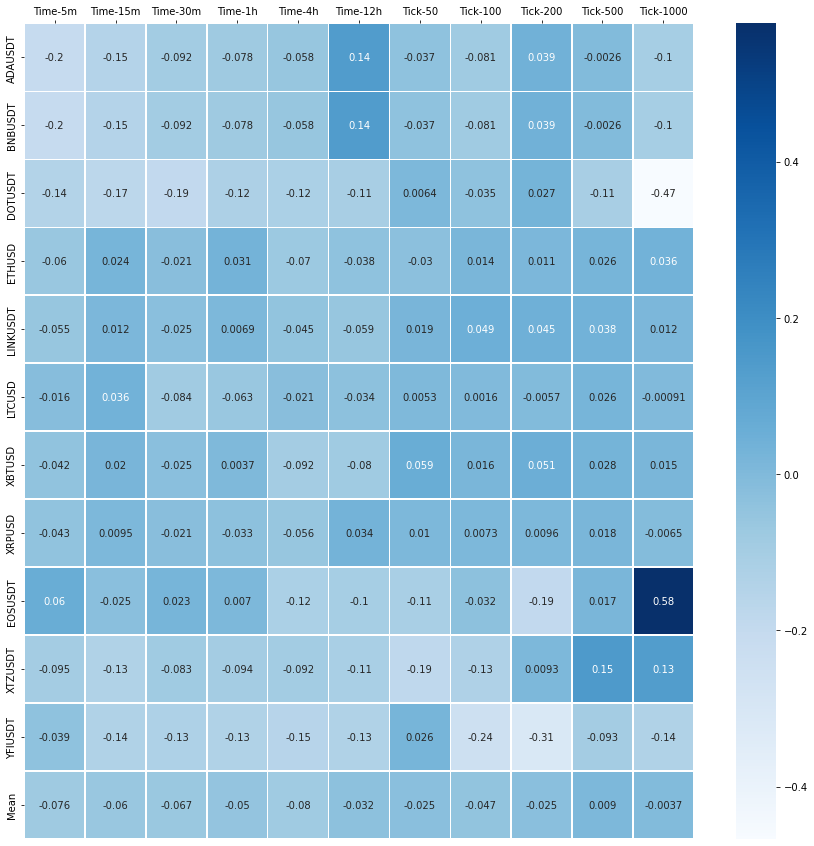

In [ ]:
row_names = ['ADAUSDT','BNBUSDT','DOTUSDT','ETHUSD','LINKUSDT','LTCUSD','XBTUSD','XRPUSD','EOSUSDT','XTZUSDT','YFIUSDT','Mean']


cormat = np.array(correlations,dtype='float64')

fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches
corrmat =  sns.heatmap(cormat, annot = True, linewidths=.5, ax=ax, xticklabels=column_names,
                       yticklabels=row_names, cmap="Blues")

ax.xaxis.set_ticks_position('top')


In [ ]:
from google.colab import files
fig = corrmat.get_figure()
fig.savefig('Correlation_Time_Tick.png')
